In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base=automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Climate Analysis

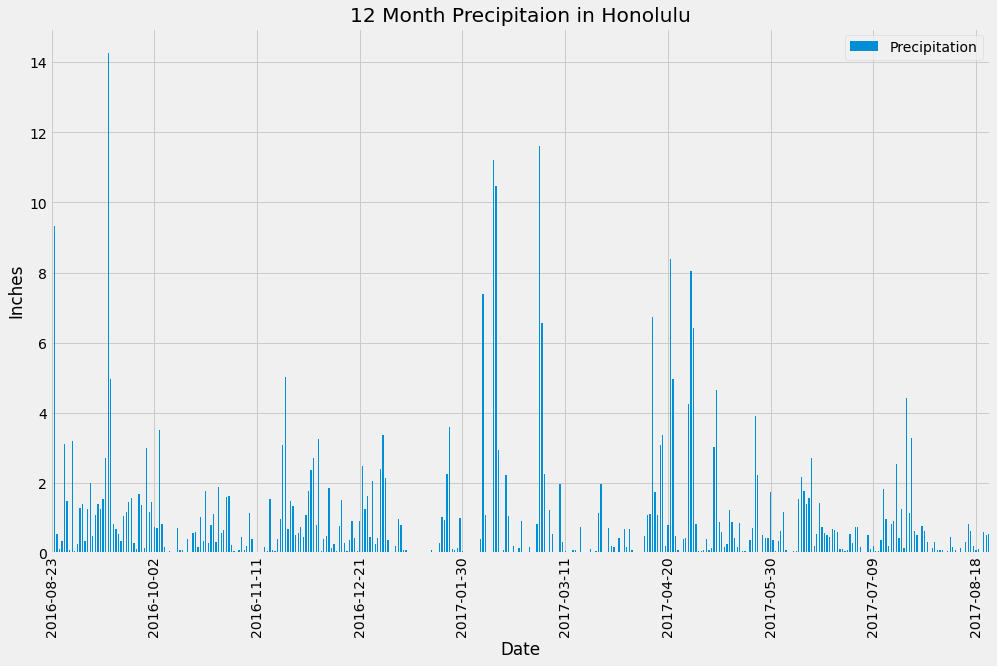

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
sbydate=session.query(Measurement).order_by(Measurement.date.desc()).first()
year=int(sbydate.date[0:4])
month=int(sbydate.date[5:7])
day=int(sbydate.date[8:10])
query_date=dt.date(year,month,day)-dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
query_period=session.query(Measurement.date,Measurement.prcp).\
                    filter(Measurement.date >= str(query_date)).\
                    filter(Measurement.prcp != "NaN").\
                    order_by(Measurement.date.desc()).all()

#for date in query_period:
#    print(f"{date.date},{date.prcp}")

# Save the query results as a Pandas DataFrame and set the index to the date column
query_df=pd.DataFrame(query_period, columns=['Date','Precipitation'])

# Sort the dataframe by date
query_by_df=query_df.groupby(['Date']).sum()

# Use Pandas Plotting with Matplotlib to plot the data
bar_chart=query_by_df.plot(kind='bar',title='12 Month Precipitaion in Honolulu',figsize=(15,9))
plt.xticks(np.arange(query_by_df.shape[0])[::40], query_by_df.index[::40])
bar_chart.set(xlabel='Date', ylabel='Inches')
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data

In [12]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(func.distinct(Measurement.station))).all()

[(9)]

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                    filter(Measurement.station=='USC00519281').all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

Station with the highest tempurature observations:  USC00519281


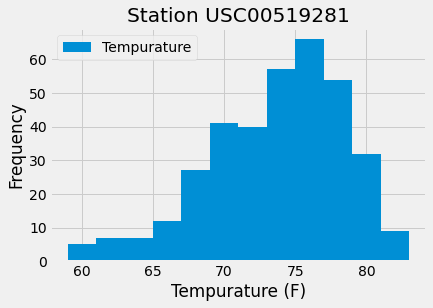

In [15]:
# Choose the station with the highest number of temperature observations.
highest_tobs=session.query(Measurement.station, func.count(Measurement.tobs)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.tobs).desc()).first()
print('Station with the highest tempurature observations: ',highest_tobs.station)

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sbydate=session.query(Measurement).\
                filter(Measurement.station==highest_tobs.station).\
                order_by(Measurement.date.desc()).first()
year=int(sbydate.date[0:4])
month=int(sbydate.date[5:7])
day=int(sbydate.date[8:10])
query_date=dt.date(year,month,day)-dt.timedelta(days=365)
query_period=session.query(Measurement.date,Measurement.tobs).\
                    filter(Measurement.station==highest_tobs.station).\
                    filter(Measurement.date >= str(query_date)).\
                    filter(Measurement.tobs != "NaN").\
                    order_by(Measurement.date.desc()).all()
query_df=pd.DataFrame(query_period, columns=['Date','Tempurature'])
bar_chart=query_df.plot(kind='hist', bins=12 ,title=f'Station {highest_tobs.station}')
bar_chart.set(xlabel='Tempurature (F)', ylabel='Frequency')
plt.show()

## Bonus Challenge Assignment

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [23]:
# Plot the daily normals as an area plot with `stacked=False`
